In [1]:
%reload_ext autoreload
%matplotlib inline

# Experiment 2: Analysis of Harmonized Data

In [2]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from src.harmonization.sitewise_scaler import SiteWiseStandardScaler
from combatlearn.combat import ComBat

INFO_FILE_PATH = 'data/ELM19/filtered/ELM19_info_filtered_norm.csv'
FEATURES_FILE_PATH = 'data/ELM19/filtered/ELM19_features_filtered_norm.csv'

COVARIATES = ['age_dec', 'patient_sex']
SITE_COLUMN = 'institution_id'

In [5]:
try:
    info_df = pd.read_csv(INFO_FILE_PATH)
    features_df = pd.read_csv(FEATURES_FILE_PATH)
    print(f"Data files loaded. Info: {info_df.shape}, Features: {features_df.shape}")
except FileNotFoundError:
    print(f"ERROR: Data files not found. Check paths.")

Data files loaded. Info: (26568, 6), Features: (26568, 2850)


In [4]:
X = features_df
y = info_df[SITE_COLUMN]
sites = info_df[SITE_COLUMN]
all_hospitals = np.unique(sites)

NameError: name 'features_df' is not defined

In [24]:
harmonizers = {
    "raw": None,

    "sitewise": SiteWiseStandardScaler(
        batch=sites
    ),

    "combat": ComBat(
        batch=sites,
        method='johnson'
    ),

    "neurocombat": ComBat(
        batch=sites,
        discrete_covariates=info_df[['patient_sex']],
        continuous_covariates=info_df[['age_dec']],
        method='fortin'
    ),

    "covbat": ComBat(
        batch=sites,
        discrete_covariates=info_df[['patient_sex']],
        continuous_covariates=info_df[['age_dec']],
        method='chen'
    )
}

In [25]:
transformed_datasets = {}

for method, harmonizer in harmonizers.items():
    print(f"Applying '{method}' transformation...")
    if harmonizer is None:
        X_scaled = StandardScaler().fit_transform(X)
        transformed_datasets[method] = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    else:
        X_transformed = harmonizer.fit_transform(X)
        X_scaled = StandardScaler().fit_transform(X_transformed)
        transformed_datasets[method] = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

Applying 'raw' transformation...
Applying 'sitewise' transformation...
Applying 'combat' transformation...
Applying 'neurocombat' transformation...
Applying 'covbat' transformation...


/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


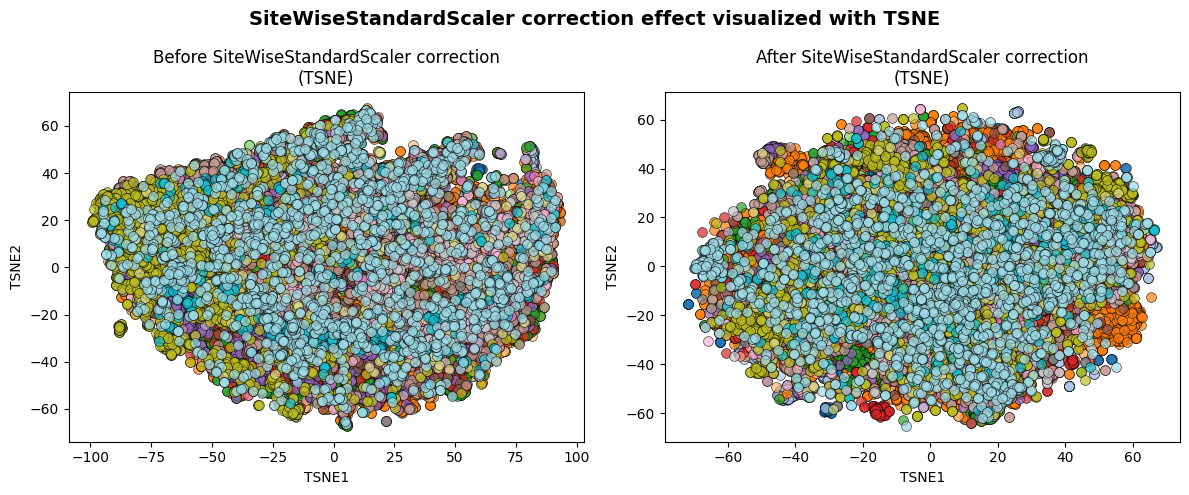

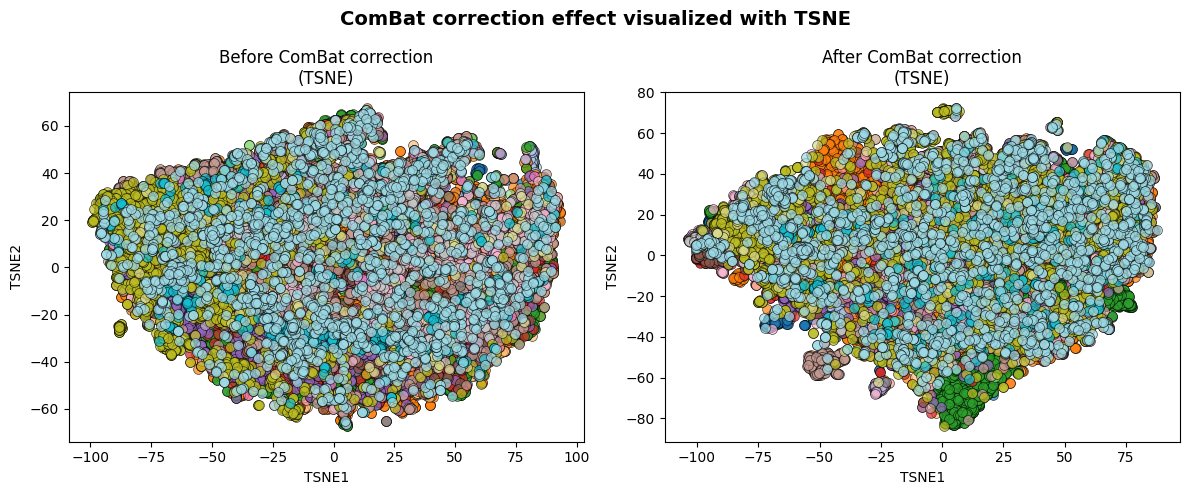

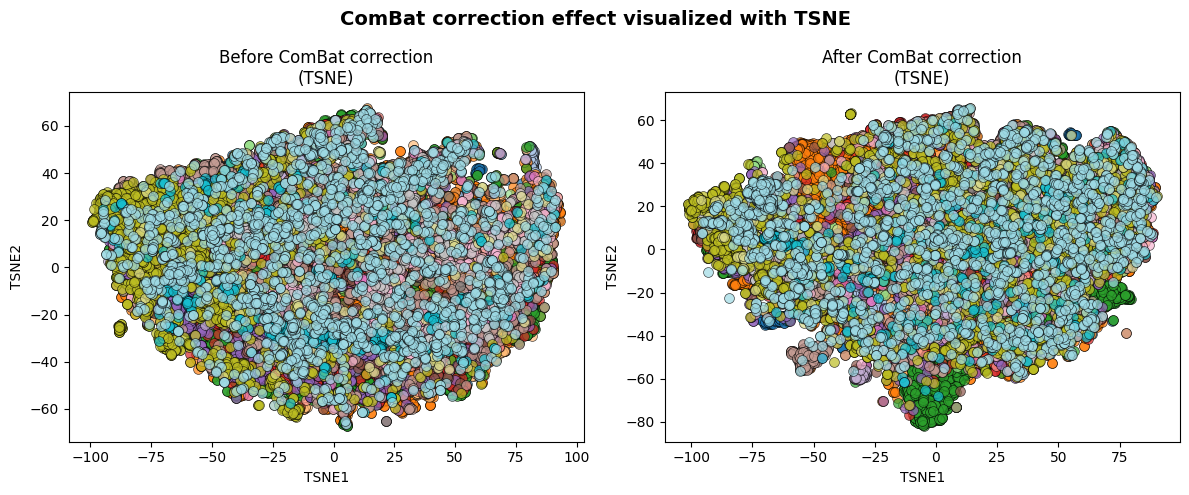

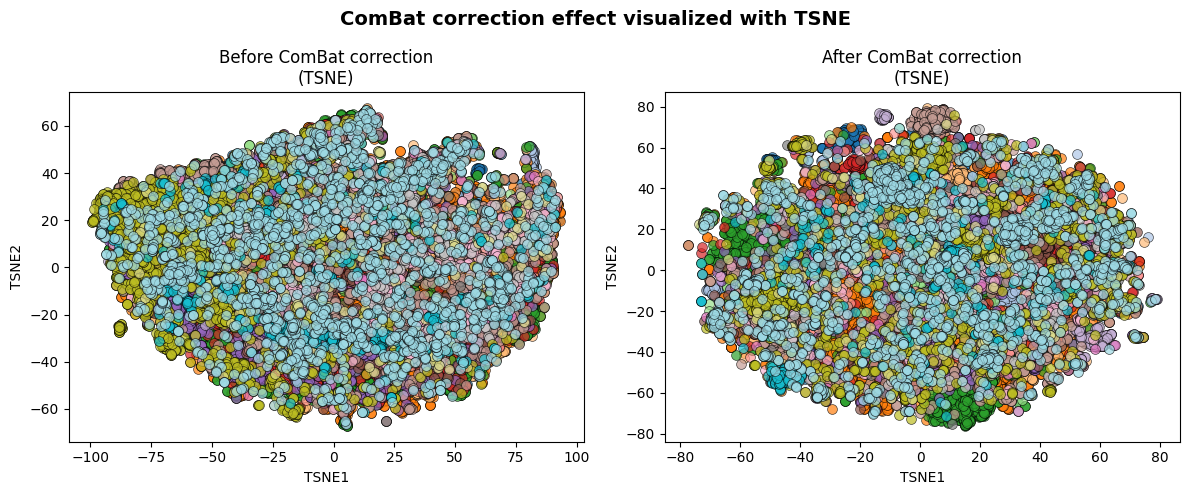

In [8]:
for method, harmonizer in harmonizers.items():
    if harmonizer is not None:
        fig = harmonizer.plot_transformation(X, reduction_method='tsne')

In [26]:
all_cov_distances = []
all_cov_matrices = {}
for method, X_transformed in transformed_datasets.items():
    cov_matrices = {}
    for site in all_hospitals:
        site_data = X_transformed[sites == site]
        cov_matrices[site] = site_data.cov().values
    all_cov_matrices[method] = cov_matrices

    for site_a, site_b in combinations(all_hospitals, 2):
        cov_a = cov_matrices[site_a]
        cov_b = cov_matrices[site_b]

        f_distance = np.linalg.norm(cov_a - cov_b, 'fro')

        all_cov_distances.append({
            'method': method,
            'comparison': f"{site_a}_vs_{site_b}",
            'frobenius_distance': f_distance
        })

In [19]:
cov_dist_df = pd.DataFrame(all_cov_distances)

plt.figure(figsize=(10, 6))
sns.violinplot(data=cov_dist_df, x='method', y='frobenius_distance',
               order=['raw', 'sitewise', 'combat', 'neurocombat', 'covbat'])
plt.title("Pairwise Distance Between Hospitals' Covariance Matrices", fontsize=16)
plt.xlabel('Harmonization Method')
plt.ylabel('Frobenius Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

NameError: name 'all_cov_distances' is not defined

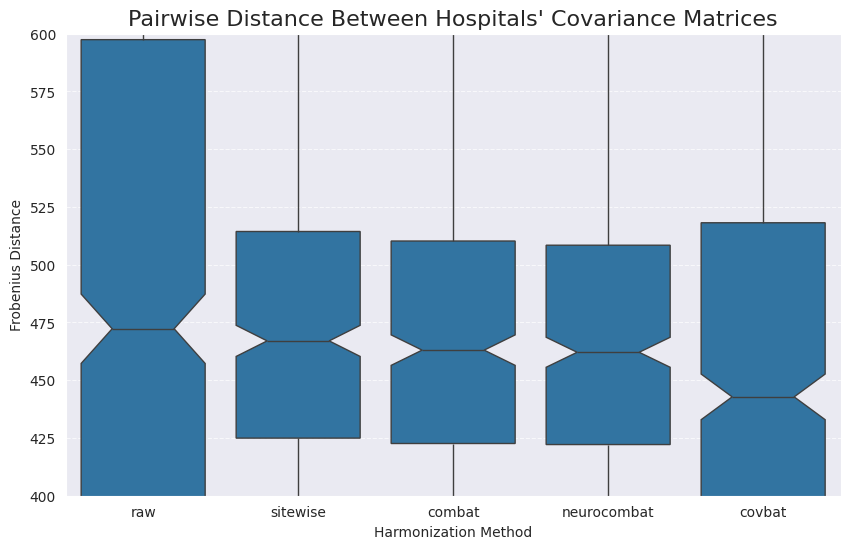

In [28]:
cov_dist_df = pd.DataFrame(all_cov_distances)

plt.figure(figsize=(10, 6))
sns.boxplot(data=cov_dist_df, x='method', y='frobenius_distance', notch=True,
               order=['raw', 'sitewise', 'combat', 'neurocombat', 'covbat'])
plt.title("Pairwise Distance Between Hospitals' Covariance Matrices", fontsize=16)
plt.xlabel('Harmonization Method')
plt.ylabel('Frobenius Distance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(400, 600)
plt.show()

In [1]:
hospital_to_compare = 0

harm_types = transformed_datasets.keys()
n_harm_types = len(harm_types)
fig, axes = plt.subplots(n_harm_types, 1,
                         figsize=(8, n_harm_types * 8),
                         sharex=True, sharey=True, dpi=500)

all_vals = np.concatenate([
    all_cov_matrices[h][hospital_id].flatten()
    for h in harm_types
    for hospital_id in all_hospitals
])
vmax = np.percentile(np.abs(all_vals), 99)
vmin = -vmax

hospital_id = all_hospitals[hospital_to_compare]

for i, harm_type in enumerate(harm_types):
    ax = axes[i]

    matrix_to_plot = all_cov_matrices[harm_type][hospital_id]

    ax.imshow(matrix_to_plot, cmap='vlag', vmin=vmin, vmax=vmax)

    if i == 0:
        ax.set_title(hospital_id, fontsize=12, fontweight='bold')

    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='vlag', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax)

plt.suptitle(f"Covariance Matrices", fontsize=16, fontweight='bold')
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)

plt.show()

NameError: name 'transformed_datasets' is not defined